In [1]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display
torch.cuda.set_device(0)
batch_size = 256

# 从0实现

In [3]:
torch.cuda.get_device_name(0)

'RTX A6000'

In [43]:
def get_dataloader_workers():
    """用4个进程读取数据"""
    return 4
    
def load_data_fashion_mnist(batch_size, resize=None):
    """下载数据集并加载到内存中"""
    # 将图像从PIL类型转换为32位浮点数格式并/255，使得像素在0~1之间
    trans = [transforms.ToTensor()]
    if resize is not None:
        trans.insert(0,transforms.Resize((resize,resize)))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans,download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans,download=True
    )
    #内置的数据迭代器，shuffle打乱样本（训练数据使用）
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers=get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle=False,
                           num_workers=get_dataloader_workers()))

In [44]:
# 单隐藏层的多层感知机，包含256个隐藏单元
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(
    torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01
)
b1 = nn.Parameter(
    torch.zeros(num_hiddens, requires_grad=True)
)
W2 = nn.Parameter(
    torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01
)
b2 = nn.Parameter(
    torch.zeros(num_outputs, requires_grad=True)
)
params = [W1,b1,W2,b2]

In [45]:
# 实现ReLU激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X,a)

In [46]:
#实现模型
def net(X):
    X = X.reshape((-1,num_inputs))
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

loss = nn.CrossEntropyLoss(reduction='none')

In [47]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) #正确预测数，预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [48]:
class Animator:
  """在动画中绘制数据"""
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
               ylim=None, xscale='linear',yscale='linear',
               fmts=('-','m--','g-','r:'),nrows=1,ncols=1,
               figsize=(3.5,2.5)):
    if legend is None:
      legend = []
    # d2l.use_svg_display()
    self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    self.X, self.Y, self.fmts = None, None, fmts
  
  def add(self, x,y):
    #向图表添加多个数据点
    if not hasattr(y,"__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x,"__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a,b) in enumerate(zip(x,y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x,y,fmt in zip(self.X,self.Y,self.fmts):
      self.axes[0].plot(x,y,fmt)
    display.display(self.fig)
    display.clear_output(wait=True)

In [49]:
# 定义训练
def train_epoch(net, train_iter, loss ,updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式(计算梯度)
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1]/metric[2]

def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel="epoch", xlim=[1,num_epochs],ylim=[0.3,0.9],
                       legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5 , train_loss
    assert train_acc <=1 and train_acc > 0.7 , train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

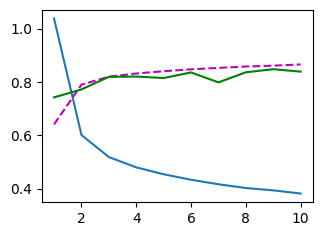

In [50]:
num_epochs, lr = 10, 0.1
train_iter, test_iter = load_data_fashion_mnist(batch_size)
updater = torch.optim.SGD(params, lr=lr)
train(net, train_iter, test_iter, loss, num_epochs, updater)

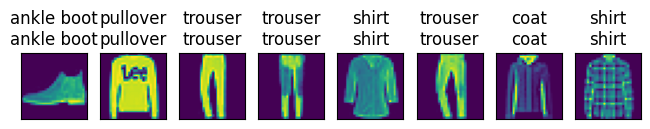

In [60]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t_shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]
    
    
def show_images(imgs, num_rows, num_cols, titles=None, scale=1):
    """绘制图像列表，可视化一下"""
    figsize = (num_cols * scale, num_rows*scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i , (ax, img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def predict(net, test_iter, n=6):
    """预测"""
    for X,y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n]
    )
    
predict(net,test_iter,n=8)

# 简洁实现

In [67]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [68]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

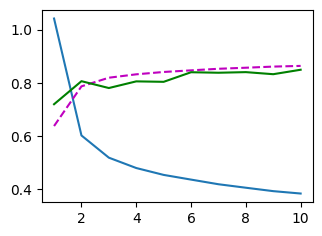

In [69]:
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train(net, train_iter, test_iter, loss, num_epochs, trainer)